In [ ]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from tqdm import tqdm_notebook
from collections import defaultdict
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Blackjack Env

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

# Monte Carlo Blackjack Gain Estimation of simple strategy (First visit)

In [ ]:
def play_episode(env):
    """
    Plays a single episode with a set policy in the environment given. Records the state, action 
    and reward for each step and returns the all timesteps for the episode.
    """
    episode = []
    state = env.reset()
    while True:
        action = 0 if sum_hand(env.player) in [19, 20, 21] else 1
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [ ]:
env = BlackjackEnv(natural=True)
gain = 0
total_episodes = 100000
for _ in tqdm_notebook(range(total_episodes)):
  episode = play_episode(env)
  gain += episode[-1][-1]
print(gain / total_episodes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



-0.182815


# Q-learning

In [ ]:
def find_best_a_for_s_by_Q(Q, s):
  return np.argmax(Q[s])

def Q_learning_episode(env, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s = env._get_obs()[:-1]
    a = find_best_a_for_s_by_Q(Q, s) if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
    while(1):
        observation, reward, done, info = env.step(a)
        if done:
            Q[s][a] = Q[s][a] + alpha * (reward - Q[s][a])  
            break
        s_prime = observation[:-1]
        a_prime = find_best_a_for_s_by_Q(Q, s_prime) if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        
def test_strategy(env, Q):
  env.reset()
  s = env._get_obs()[:-1]
  a = np.argmax(Q[s])
  while(1):
    observations, reward, done, _ = env.step(a)
    s = observations[:-1]
    a = np.argmax(Q[s])
    if done:
      break
  return reward

## Base Blackjack

In [ ]:
total_episodes = 1000000
total_episodes_test = 100000
avg_rewards = {}
env = BlackjackEnv(natural=True)
epsilon = np.linspace(0, 0.4, 4)

for eps in epsilon:
  Q = defaultdict(lambda: np.random.random(env.action_space.n))
  Q_rewards = []
  for i in tqdm_notebook(range(total_episodes)):
    Q_learning_episode(env, Q, epsilon=eps, alpha=0.2)
    if i % 100000 == 0:
      reward = 0.
      for _ in range(total_episodes_test):
        reward += test_strategy(env, Q)
      Q_rewards.append(reward / total_episodes_test)
  reward = 0.
  for _ in range(total_episodes_test):
        reward += test_strategy(env, Q)
  Q_rewards.append(reward / total_episodes_test)
  avg_rewards[str(eps)] = Q_rewards

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


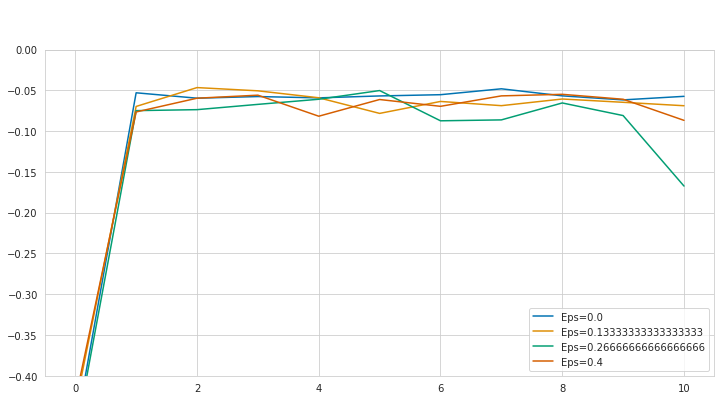

In [ ]:
fig = plt.figure(figsize=(12, 6))
for eps in avg_rewards.keys():
  plt.plot(range(len(avg_rewards[eps])), avg_rewards[eps], label=f"Eps={eps}")
plt.suptitle("Reward from Q-learning", color='white')
plt.ylim((-0.4, 0))
plt.legend()

## Double Blackjack

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvDouble(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        else:
          done = True
          self.player.append(draw_card(self.np_random))
          while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
          reward = cmp(score(self.player), score(self.dealer))
          if self.natural and is_natural(self.player) and reward == 1.:
              reward = 1.5
          reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [ ]:
total_episodes = 1000000
total_episodes_test = 100000
avg_rewards = {}
env = BlackjackEnvDouble(natural=True)
epsilon = np.linspace(0, 0.4, 4)
for eps in epsilon:
  Q = defaultdict(lambda: np.random.random(env.action_space.n))
  Q_rewards = []
  for i in tqdm_notebook(range(total_episodes)):
    Q_learning_episode(env, Q, epsilon=eps, alpha=0.005)
    if i % 100000 == 0:
      reward = 0.
      for _ in range(total_episodes_test):
        reward += test_strategy(env, Q)
      Q_rewards.append(reward / total_episodes_test)
  reward = 0.
  for _ in range(total_episodes_test):
    reward += test_strategy(env, Q)
  Q_rewards.append(reward / total_episodes_test)
  avg_rewards[str(eps)] = Q_rewards

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


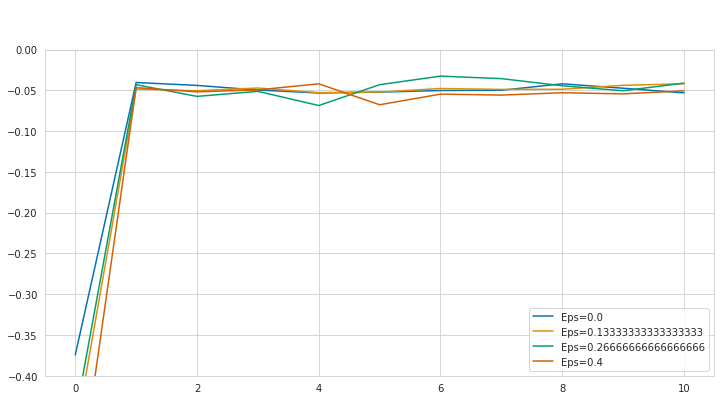

In [ ]:
fig = plt.figure(figsize=(12, 6))
for eps in avg_rewards.keys():
  plt.plot(range(len(avg_rewards[eps])), avg_rewards[eps], label=f"Eps={eps}")
plt.suptitle("Reward from Q-learning", color='white')
plt.ylim((-0.4, 0))
plt.legend()

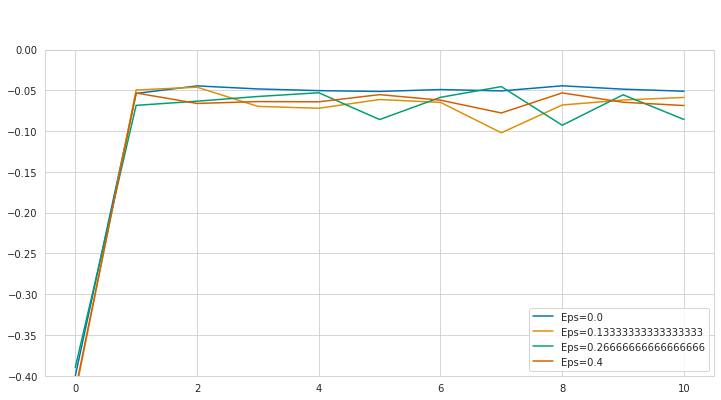

In [ ]:
fig = plt.figure(figsize=(12, 6))
for eps in avg_rewards.keys():
  plt.plot(range(len(avg_rewards[eps])), avg_rewards[eps], label=f"Eps={eps}")
plt.suptitle("Reward from Q-learning", color='white')
plt.ylim((-0.4, 0))
plt.legend()

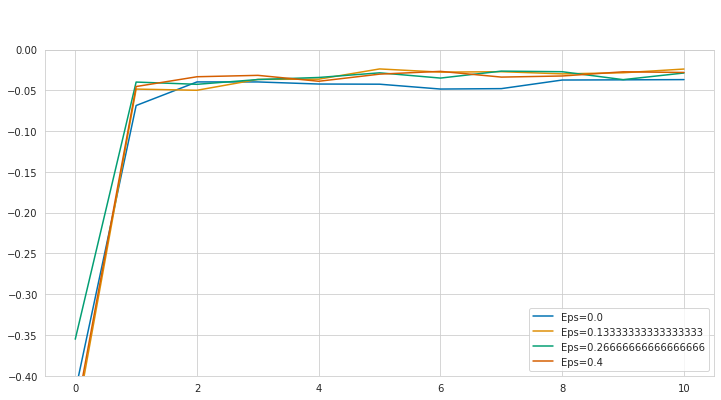

In [ ]:
fig = plt.figure(figsize=(12, 6))
for eps in avg_rewards.keys():
  plt.plot(range(len(avg_rewards[eps])), avg_rewards[eps], label=f"Eps={eps}")
plt.suptitle("Reward from Q-learning", color='white')
plt.ylim((-0.4, 0))
plt.legend()

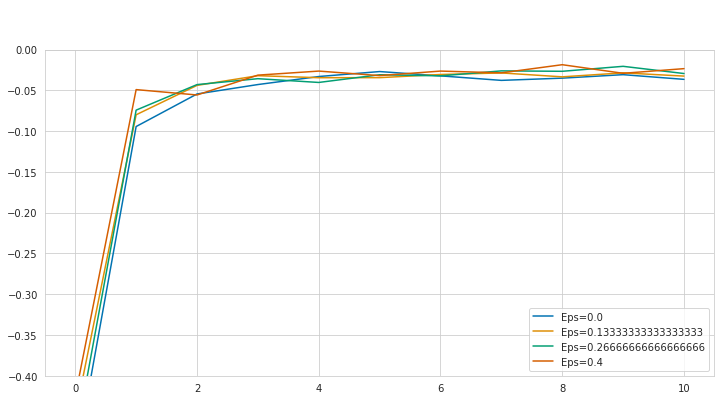

In [ ]:
fig = plt.figure(figsize=(12, 6))
for eps in avg_rewards.keys():
  plt.plot(range(len(avg_rewards[eps])), avg_rewards[eps], label=f"Eps={eps}")
plt.suptitle("Reward from Q-learning", color='white')
plt.ylim((-0.4, 0))
plt.legend()

## Double Blackjack with cards count

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10


def draw_card(np_random, deck):
    card = int(np_random.choice(deck))
    new_deck = remove_card_from_deck(deck, card)
    return card, new_deck

def draw_hand(np_random, deck):
    card1, new_deck1 = draw_card(np_random, deck)
    card2, new_deck2 = draw_card(np_random, new_deck1)
    return [card1, card2], new_deck2


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

def shuffle_deck():
    return list(np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10], 4))

def remove_card_from_deck(deck, card):
    card_index = np.searchsorted(deck, card)
    return list(np.delete(deck, card_index))
    

class BlackjackEnvDoubleCount(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        # self.observation_space = spaces.Tuple((
        #     spaces.Discrete(32),
        #     spaces.Discrete(11),
        #     spaces.Discrete(),
        #     spaces.Discrete(2)))
        self.seed()
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        # self.reset()
        self.count_cards = 0
        self.deck = list(np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10], 4))
        self.n_card_in_deck = len(self.deck)
        self.cards_to_score = {
            1: 0,
            2: 1,
            3: 1,
            4: 2,
            5: 2,
            6: 2,
            7: 1,
            8: 0,
            9: -1,
            10:	-2
        }
        # self.cards_to_score = {
        #     1: -1,
        #     2: 0.5,
        #     3: 1,
        #     4: 1,
        #     5: 1.5,
        #     6: 1,
        #     7: 0.5,
        #     8: 0,
        #     9: -0.5,
        #     10:	-1
        # }
        # self.cards_to_score = {
        #     1: -1,
        #     2: 1,
        #     3: 1,
        #     4: 1,
        #     5: 1,
        #     6: 1,
        #     7: 0,
        #     8: 0,
        #     9: 0,
        #     10:	-1
        # }

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            new_card, self.deck = draw_card(self.np_random, self.deck)
            self.player.append(new_card)
            self.n_card_in_deck -= 1
            self.count_cards += self.cards_to_score[new_card]
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                new_card, self.deck = draw_card(self.np_random, self.deck)
                self.dealer.append(new_card)
                self.n_card_in_deck -= 1
                self.count_cards += self.cards_to_score[new_card]
            self.count_cards += self.cards_to_score[self.dealer[1]] # ???
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        else:
          done = True
          new_card, self.deck = draw_card(self.np_random, self.deck)
          self.player.append(new_card)
          self.n_card_in_deck -= 1
          self.count_cards += self.cards_to_score[new_card]
          while sum_hand(self.dealer) < 17:
                new_card, self.deck = draw_card(self.np_random, self.deck)
                self.dealer.append(new_card)
                self.n_card_in_deck -= 1
                self.count_cards += self.cards_to_score[new_card]
          self.count_cards += self.cards_to_score[self.dealer[1]]
          reward = cmp(score(self.player), score(self.dealer))
          if self.natural and is_natural(self.player) and reward == 1.:
              reward = 1.5
          reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], self.count_cards, usable_ace(self.player))

    def reset(self):
# Shuffle deck if it's length less than 15      
        if self.n_card_in_deck < 15:
            self.deck = shuffle_deck()
            self.count_cards = 0
            self.n_card_in_deck = len(self.deck)
        self.player, self.deck = draw_hand(self.np_random, self.deck)
        self.dealer, self.deck = draw_hand(self.np_random, self.deck)       
        self.n_card_in_deck -= 4
# Count cards at reset        
        self.count_cards = self.count_cards + (
            self.cards_to_score[self.player[0]] + 
            self.cards_to_score[self.player[1]] + self.cards_to_score[self.dealer[0]])
        return self._get_obs()

In [ ]:
total_episodes = 1000000
total_episodes_test = 100000
avg_rewards = {}
env = BlackjackEnvDoubleCount(natural=True)
# epsilon = np.linspace(0, 0.4, 4)
eps = 0.1
Q = defaultdict(lambda: np.random.random(env.action_space.n))
Q_rewards = []
for i in tqdm_notebook(range(total_episodes)):
  Q_learning_episode(env, Q, epsilon=eps, gamma=1, alpha=0.1)
  if i % 100000 == 0:
    reward = 0.
    for _ in range(total_episodes_test):
      reward += test_strategy(env, Q)
    Q_rewards.append(reward / total_episodes_test)
reward = 0.
for _ in range(total_episodes_test):
  reward += test_strategy(env, Q)
Q_rewards.append(reward / total_episodes_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


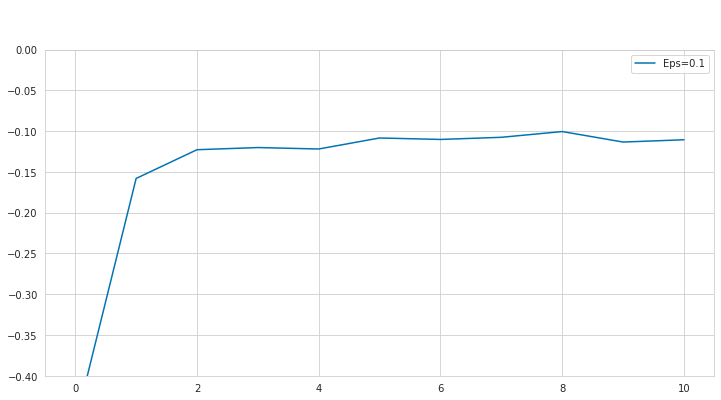

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(range(len(Q_rewards)), Q_rewards, label=f"Eps={eps}")
plt.suptitle(f"Reward from Q-learning, Alpha={0.1}, Gamma={1.0}", color='white')
plt.ylim((-0.4, 0))
plt.legend()